# Continuum Normalization

Any algorithm relying on absorption or emmission lines, such as ALIAS, benefits greatly from continuum normalization, which is the process of normalizing the continuum of a spectrum to 1, allowing the features to be more easily identified and measured.

This notebook outlines the process used for continuum normalization.

In [1]:
import alias
import alias.injection as inj

import numpy as np
import matplotlib.pyplot as plt

import scipy

import tqdm.autonotebook as tqdm

import math

/home/jhand/.conda/envs/dev/lib/python3.11/site-packages/alias/injection.py:30: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


We first must obtain spectra to be used, using the following code.

In [2]:
with open('../data/sample_star_urls_rev2', 'r') as f:
    urls = f.read().splitlines()

files = [ '../data/spectra_rev2/%s' %url.split('/')[-1] for url in urls ]

ds = alias.loadDataset(files)

/home/jhand/.conda/envs/dev/lib/python3.11/site-packages/alias/__init__.py:57: RuntimeWarning: divide by zero encountered in power
  spec_ivar_parts = np.array(hdul[2].data)**-2


As the APOGEE spectra are divided across multiple CCDs, with small gaps in between them, it is beneficial to normalize each one individually, by plotting the spectra, the two gaps were determined to exist at pixel indices 3400 and 6250

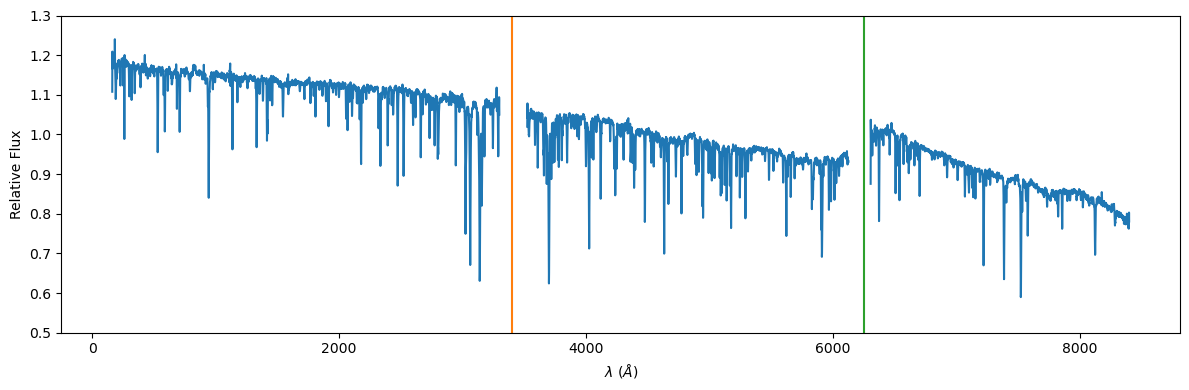

In [3]:
plt.figure(figsize=(12,4))

plt.plot(ds.flux[101])
plt.plot([3400]*2, (0,2))
plt.plot([6250]*2, (0,2))
plt.ylim(0.5, 1.3)

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'Relative Flux')


plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'Relative Flux')

_ = plt.tight_layout()

We can now implement the actual algorithm.

Continuum normalization is usually performed by identifying continuum pixels that are not affected by sharp spectral features and fitting a polynomial to them. This polynomial can then be divided out to set the continuum of the spectrum to 1.

To demonstrate this process, we will use one of the spectra from the dataset and continuum normalize it whille visuallizing the various steps involved. SHown below is the unmodified spectrum.

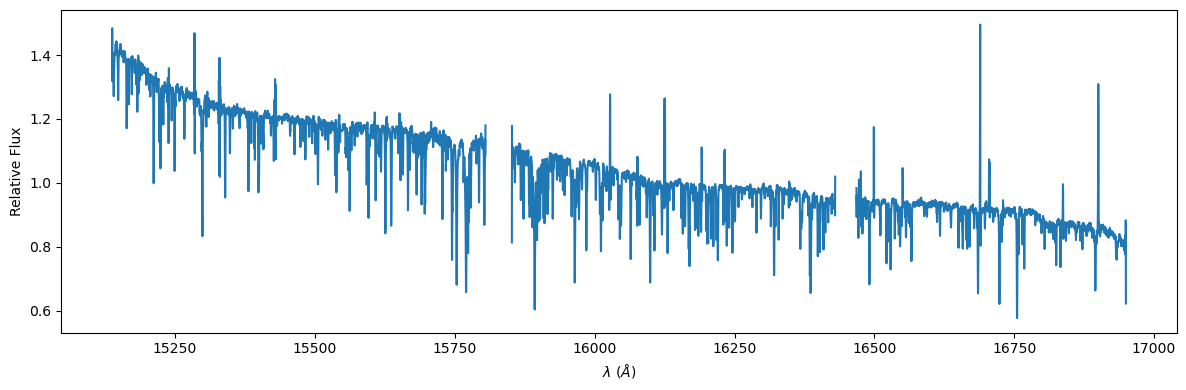

In [4]:
plt.figure(figsize=(12,4))

# Use this variable to chenge which spectrum to use
spec = 103

plt.plot(ds.wave, ds.flux[spec])

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'Relative Flux')

_ = plt.tight_layout()

The first step is to select continuum pixels. For a small number of spectra, this could be done manually, but our dataset is too large to do this, so we must select them automatically.

The way this is done is by dividing the spectrum up into small pieces and finding pixels within a certain percentile range. Shown below is the spectrum folded into 100 pixel segments, each of which will be processes separately.

8575
8600
(86, 100)


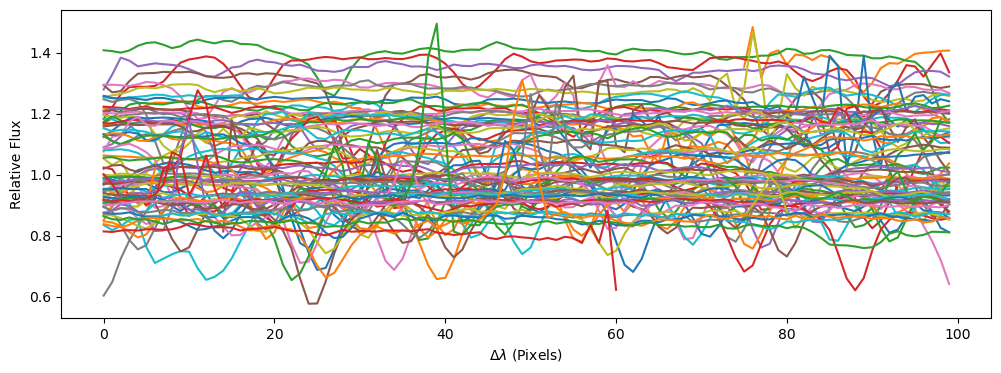

In [5]:
# Split the flux array into many 100-pixel segments

segment_len = 100

flux = np.concatenate((ds.flux[spec], [math.nan]*(segment_len - len(ds.wave) % segment_len)))

print(len(ds.wave))
print(len(flux))

f_idx = np.array([ range(segment_len*n, segment_len*n+segment_len) for n in range(0, int(len(flux)/segment_len)) ])
flux_segments = flux[f_idx]

print(np.shape(flux_segments))

plt.figure(figsize=(12,4))
plt.plot(flux_segments.T)
plt.xlabel(r'$\Delta\lambda$ (Pixels)')
_ = plt.ylabel(r'Relative Flux')

We now find the 70th and 90th percentiles of flux within each segment. Pixels lying between these to values within a segment are considered continuum pixels. These numbers were selected by eye to balance the number of pixels verses the quality of the continuum they create.

Below we plot the percentile ranges found for each segment, as expected, they follow the same overall shape of the original spectrum.

(86,)
(86,)


/home/jhand/.conda/envs/dev/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


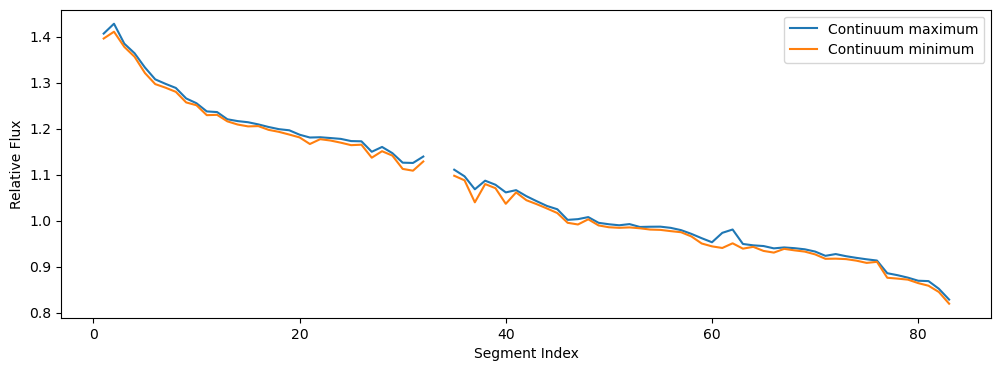

In [6]:
# Get pixels in percentile range 70-90
max_perc = np.nanpercentile(flux_segments, 90, axis=1)
min_perc = np.nanpercentile(flux_segments, 70, axis=1)

print(np.shape(max_perc))
print(np.shape(min_perc))

plt.figure(figsize=(12,4))
plt.plot(max_perc, label='Continuum maximum')
plt.plot(min_perc, label='Continuum minimum')
plt.xlabel(r'Segment Index')
plt.ylabel(r'Relative Flux')
_ = plt.legend()

We can now identify and plot the continuum pixels for a single segment, as is done below. Note how both the emmission and absorption features are excluded from the continuum.

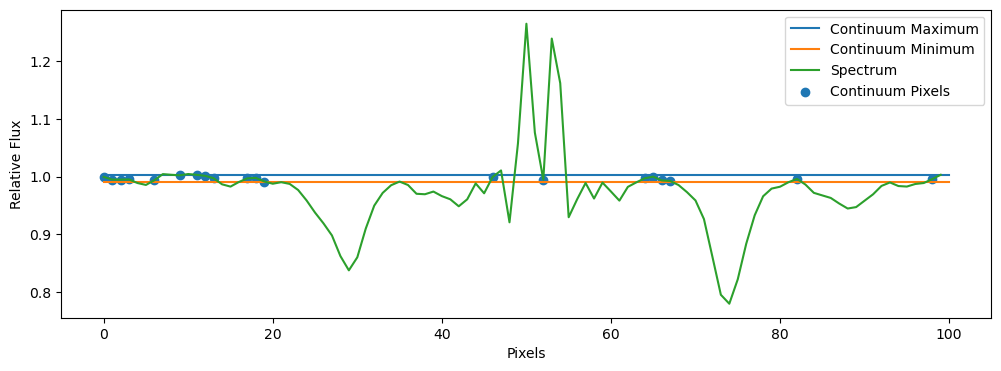

In [7]:
n = 47

continuum_mask = (flux_segments[n] > min_perc[n]) & (flux_segments[n] < max_perc[n])

plt.figure(figsize=(12,4))
plt.plot((0,segment_len), [max_perc[n]]*2, label='Continuum Maximum')
plt.plot((0,segment_len), [min_perc[n]]*2, label='Continuum Minimum')
plt.plot(flux_segments[n], label='Spectrum')

plt.scatter(np.array(range(0, segment_len))[continuum_mask], flux_segments[n][continuum_mask], label='Continuum Pixels')
plt.xlabel(r'Pixels')
plt.ylabel(r'Relative Flux')
_ = plt.legend()

We now combine all continuum pixels for all segments into a single long list, which we again plot against the original spectrum.

Number of continuum pixels: 1559


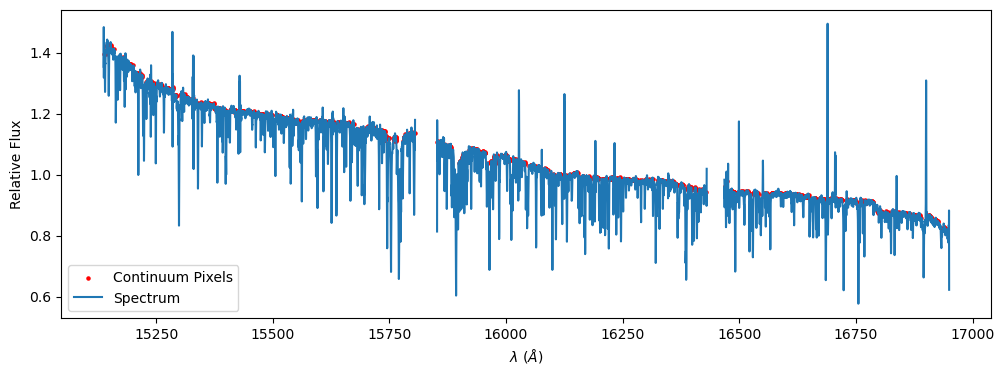

In [8]:
all_continuum_pixels = [ np.where((flux_segments[n] > min_perc[n]) & (flux_segments[n] < max_perc[n]))[0] + segment_len*n for n in range(len(flux_segments)) ]
all_continuum_pixels = np.concatenate(all_continuum_pixels)

print('Number of continuum pixels: %i' %len(all_continuum_pixels))


plt.figure(figsize=(12,4))

plt.scatter(ds.wave[all_continuum_pixels], ds.flux[spec][all_continuum_pixels], label='Continuum Pixels', color='red', s=5)
plt.plot(ds.wave, ds.flux[spec], label='Spectrum')

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'Relative Flux')
_ = plt.legend()

We now divide the continuum pixels up based on which CCD they fall into, and fit a 6th order polynomial to each.

In [9]:
# Perform continuum fits for all CCDs
cont1 = all_continuum_pixels[(all_continuum_pixels < 3400)]
fit1 = np.polyfit(cont1, ds.flux[spec][cont1], 6)

cont2 = all_continuum_pixels[(all_continuum_pixels > 3400) & (all_continuum_pixels < 6250)]
fit2 = np.polyfit(cont2, ds.flux[spec][cont2], 6)

cont3 = all_continuum_pixels[(all_continuum_pixels > 6250)]
fit3 = np.polyfit(cont3, ds.flux[spec][cont3], 6)

print(fit1)
print(fit2)
print(fit3)

cont1 = np.polyval(fit1, range(len(ds.wave)))
cont2 = np.polyval(fit2, range(len(ds.wave)))
cont3 = np.polyval(fit3, range(len(ds.wave)))

[ 5.79922622e-21 -5.60058540e-17  2.09891508e-13 -4.10528010e-10
  5.16504867e-07 -5.19890749e-04  1.50951885e+00]
[ 4.25300701e-20 -1.24541583e-15  1.50730474e-11 -9.64949852e-08
  3.44609039e-04 -6.51027963e-01  5.09512679e+02]
[-6.26112480e-20  2.71333014e-15 -4.88878621e-11  4.68752717e-07
 -2.52258955e-03  7.22404994e+00 -8.59974390e+03]


We now plot these fits to verify that the do follow the continuum of the spectrum.

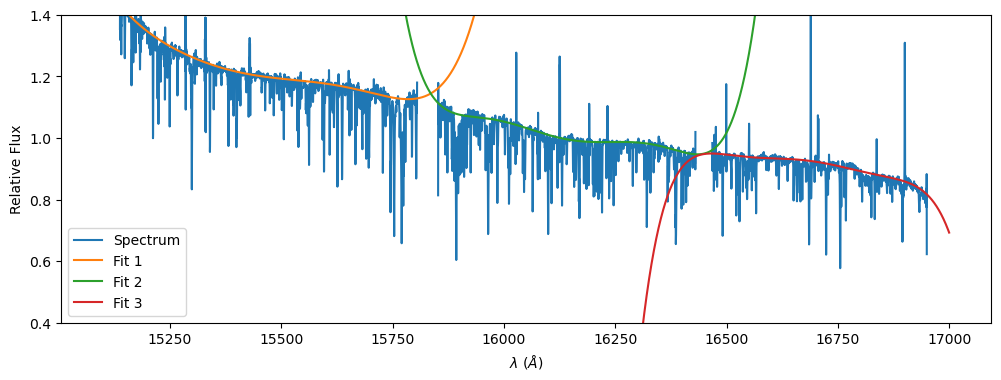

In [10]:
# Plot the fits to verify they are acceptable


plt.figure(figsize=(12,4))

plt.plot(ds.wave, ds.flux[spec], label='Spectrum')
plt.plot(ds.wave, cont1, label='Fit 1')
plt.plot(ds.wave, cont2, label='Fit 2')
plt.plot(ds.wave, cont3, label='Fit 3')

plt.ylim(0.4, 1.4)

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'Relative Flux')
_ = plt.legend()

Now we splice these fits together into a single continuum.

(8575,)


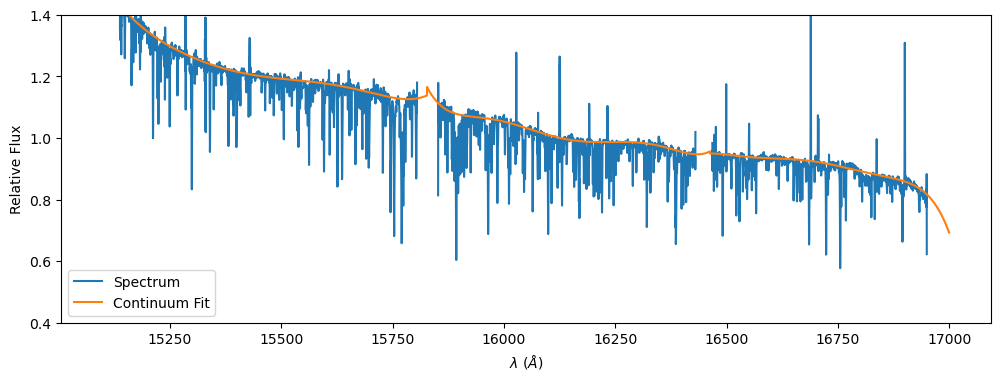

In [11]:
continuum = np.concatenate((cont1[:3400], cont2[3400:6250], cont3[6250:]))

print(np.shape(continuum))

plt.figure(figsize=(12,4))

plt.plot(ds.wave, ds.flux[spec], label='Spectrum')
plt.plot(ds.wave, continuum, label='Continuum Fit')

plt.ylim(0.4, 1.4)

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'Relative Flux')
_ = plt.legend()

This continuum can now be divided out of the original spectrum to achieve a continuum normalized version of the original spectrum.

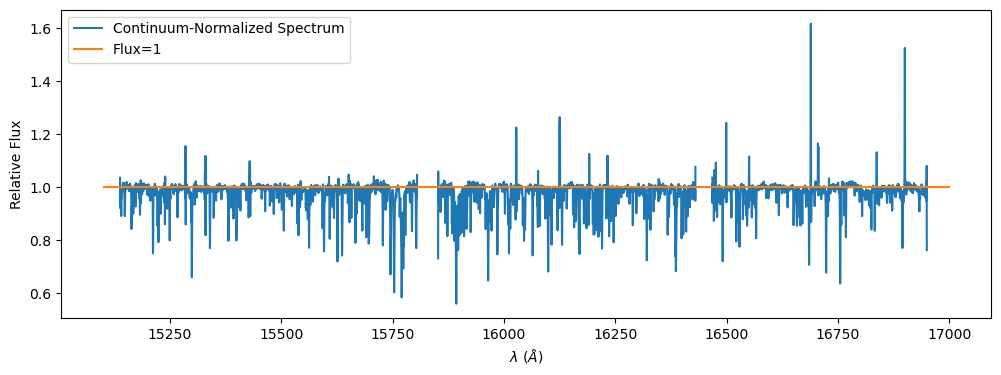

In [12]:
normalized_flux = ds.flux[spec] / continuum


plt.figure(figsize=(12,4))

plt.plot(ds.wave, normalized_flux, label='Continuum-Normalized Spectrum')
plt.plot((np.min(ds.wave), np.max(ds.wave)), (1,1), label='Flux=1')

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'Relative Flux')
_ = plt.legend()

We also plot the original spectrum again for comparison.

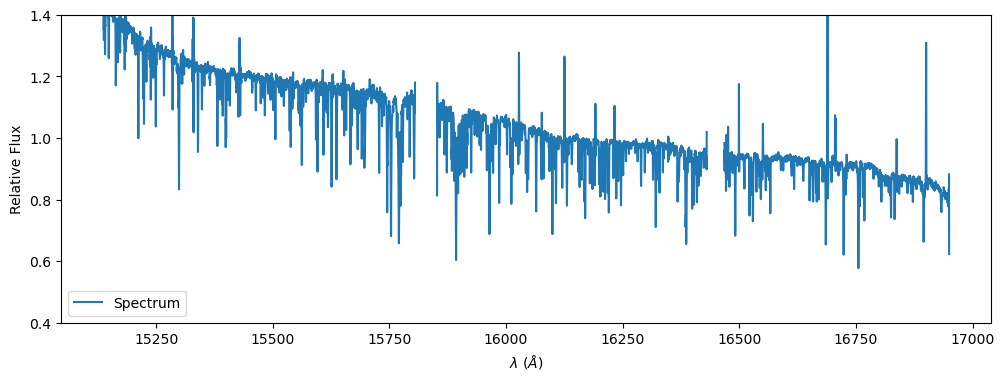

In [13]:
# Plot original spectrum to compare

plt.figure(figsize=(12,4))

plt.plot(ds.wave, ds.flux[spec], label='Spectrum')

plt.ylim(0.4, 1.4)

plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel(r'Relative Flux')
_ = plt.legend()

We now combine this entire process into a single function that can be used to cintunuum normalize any collection spectrectra. As one final sanity check, we can plo all the spectra in our dataset and verify that they are all continuum normalized appropriately.

In [14]:
def _cn(flux, segment_len=100):
    
    flux = np.concatenate((flux, [math.nan]*(segment_len - len(flux) % segment_len)))
    
    f_idx = np.array([ range(segment_len*n, segment_len*n+segment_len) for n in range(0, int(len(flux)/segment_len)) ])
    flux_segments = flux[f_idx]
    
    max_perc = np.nanpercentile(flux_segments, 80, axis=1)
    min_perc = np.nanpercentile(flux_segments, 70, axis=1)
    
    all_continuum_pixels = np.concatenate([ 
        np.where((flux_segments[n] > min_perc[n]) & (flux_segments[n] < max_perc[n]))[0] + segment_len*n 
        for n in range(len(flux_segments))
    ])

    cont1 = all_continuum_pixels[(all_continuum_pixels < 3400)]
    fit1 = np.polyfit(cont1, flux[cont1], 6)
    cont2 = all_continuum_pixels[(all_continuum_pixels > 3400) & (all_continuum_pixels < 6250)]
    fit2 = np.polyfit(cont2, flux[cont2], 6)
    cont3 = all_continuum_pixels[(all_continuum_pixels > 6250)]
    fit3 = np.polyfit(cont3, flux[cont3], 6)
        
    cont1 = np.polyval(fit1, range(len(flux)))
    cont2 = np.polyval(fit2, range(len(flux)))
    cont3 = np.polyval(fit3, range(len(flux)))
    
    continuum = np.concatenate((cont1[:3400], cont2[3400:6250], cont3[6250:]))

    return continuum

def continuum_normalize(flux, ivar):
    continuums = np.array([ _cn(f) for f in tqdm.tqdm(flux) ])[:,range(len(flux[0]))]
    return flux/continuums, ivar*continuums**2

In [15]:
norm_flux, norm_ivar = continuum_normalize(ds.flux, ds.ivar)

  0%|          | 0/1254 [00:00<?, ?it/s]

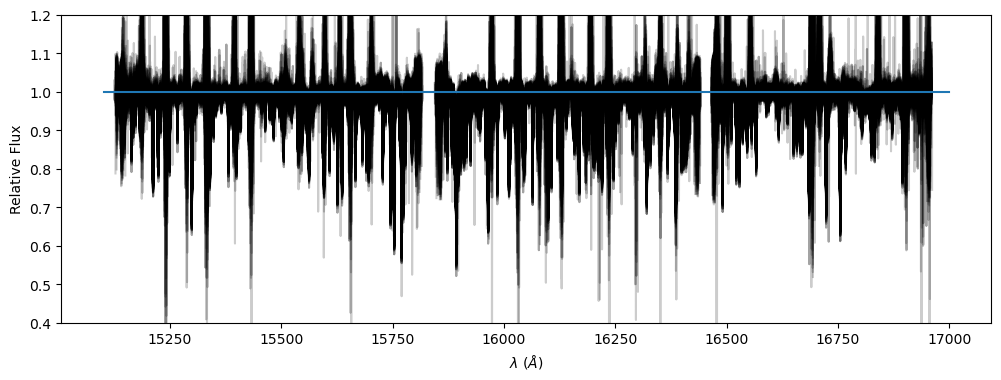

In [16]:

plt.figure(figsize=(12,4))

plt.plot(ds.wave, norm_flux.T, alpha=0.2,  color='black')
plt.plot((np.min(ds.wave), np.max(ds.wave)), (1,1), label='Flux=1')
plt.ylim(0.4, 1.2)

plt.xlabel(r'$\lambda$ ($\AA$)')
_ = plt.ylabel(r'Relative Flux')